In [1]:
import numpy as np

from steenroder import *
import gudhi

from matplotlib import pyplot as plt

from scipy.io import loadmat

from sklearn.manifold import Isomap
from hdbscan import HDBSCAN

from gtda.plotting import plot_point_cloud

This dataset of 6040 samples from the configuration space of the cyclo-octane molecule $C_{8} H_{16}$ is described in https://www.frontiersin.org/articles/10.3389/frai.2021.668302/full#B48 as follows:

> What do we mean by “global shape”? Consider, for example, conformations of the cyclo-octane molecule $C_8 H_{16}$, which consists of a ring of eight carbons atoms, each bonded to a pair of hydrogen atoms (see Figure 4, left). The locations of the carbon atoms in a conformation approximately determine the locations of the hydrogen atoms via energy minimization, and hence each molecule conformation can be mapped to a point in $\mathbb{R}^{24} = \mathbb{R}^{8 \cdot 3}$, as the location of each carbon atom can be specified by three coordinates. This map realizes the conformation space of cyclo-octane as a subset of $\mathbb{R}^{24}$, and then we mod out by rigid rotations and translations. Topologically, the conformation space of cyclo-octane turns out to be the union of a sphere with a Klein bottle, glued together along two circles of singularities (see Figure 4, right). This model was obtained by Martin et al. (2010), Martin and Watson (2011), and Brown et al. (2008), who furthermore obtain a triangulation of this dataset (a representation of the dataset as a union of vertices, edges, and triangles).

In [2]:
cyclo_octane = loadmat("../data/pointsCycloOctane.mat")['pointsCycloOctane']
cyclo_octane.shape

(6040, 24)

The circles of singularities can be found by several methods. Traditionally, local PCA was used. Here, we use the singular set found by using the methods in https://www.pnas.org/content/117/33/19664:

In [3]:
singular_indices = loadmat("singularity_indicesCycloOctane_PH0.5.mat")['singularity_indices_PH'].flatten() - 1
nonsingular_indices = np.array([x for x in range(len(cyclo_octane)) if x not in singular_indices])
print(f"{len(singular_indices)} points in the singular set")

627 points in the singular set


Let us store the non-singular portion for later use

In [4]:
cyclo_octane_nonsingular = cyclo_octane[nonsingular_indices]

A dimensionality reduction algorithm such as ISOMAP can help us visualize the full dataset in 3D:

In [5]:
isomap = Isomap(n_components=3).fit_transform(cyclo_octane)

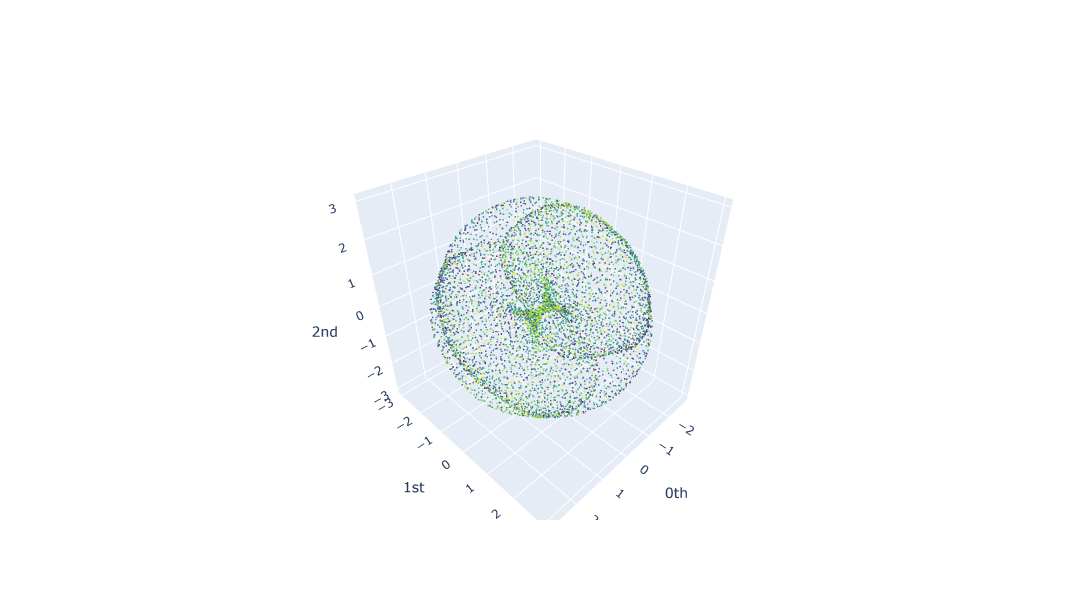

In [6]:
plot_point_cloud(isomap, plotly_params={"trace": {"marker_size": 1},
                                        "layout": {"height": 600, "width": 600}})

And we can also visualize the singular and non-singular portions:

In [7]:
isomap_nonsingular = isomap[nonsingular_indices]
isomap_singular = isomap[singular_indices]

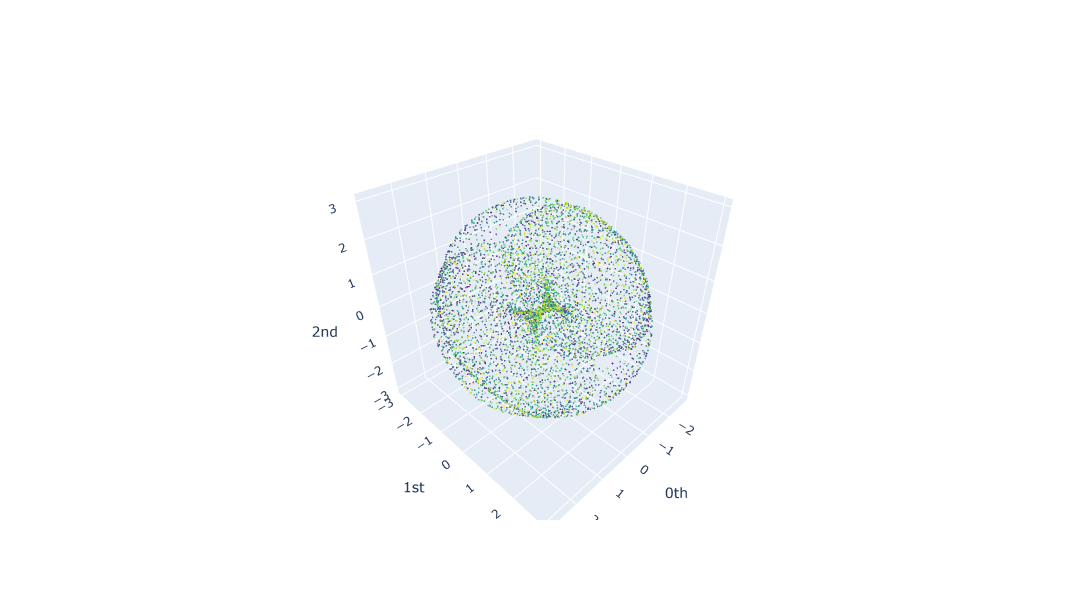

In [8]:
plot_point_cloud(isomap_nonsingular, plotly_params={"trace": {"marker_size": 1},
                                                    "layout": {"height": 600, "width": 600}})

We can see that the singular set does look like two circles in the ISOMAP projection:

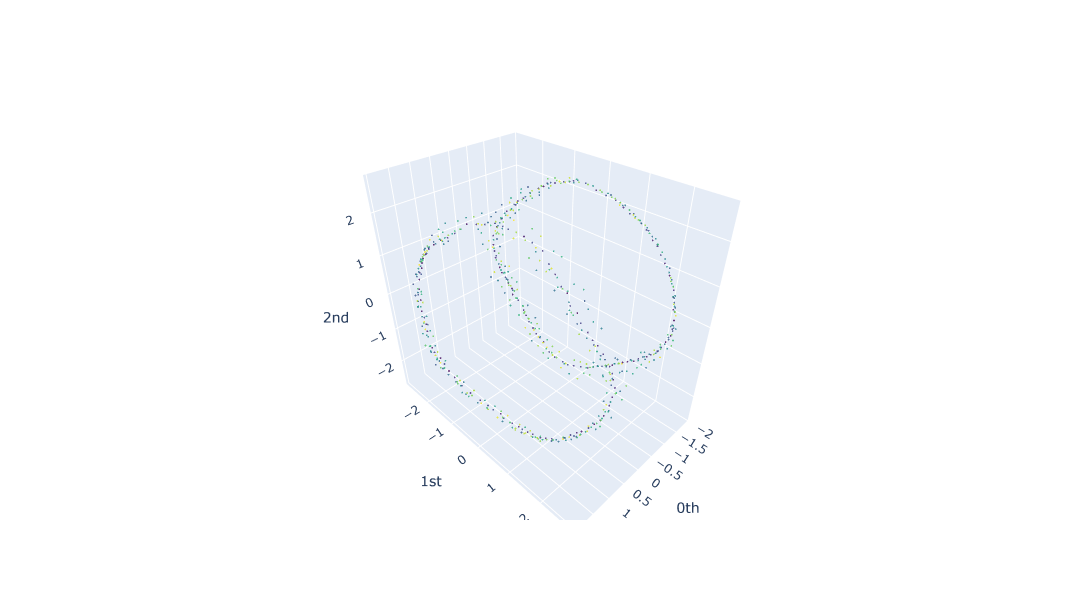

In [9]:
plot_point_cloud(isomap_singular, plotly_params={"trace": {"marker_size": 1},
                                                 "layout": {"height": 600, "width": 600}})

From previous literature, we expect the nonsingular part of the data to be the union of a 2-sphere and a Klein bottle. We partition the non-singular part using the clustering algorithm HDBSCAN:

In [10]:
HD = HDBSCAN(min_samples=2, min_cluster_size=300, alpha=1., cluster_selection_epsilon=0)
HD.fit(cyclo_octane_nonsingular)

HDBSCAN(cluster_selection_epsilon=0, min_cluster_size=300, min_samples=2)

With these hyperparameters, the portion we are interested in turns out to be the cluster labelled as `3` by HDBSCAN:

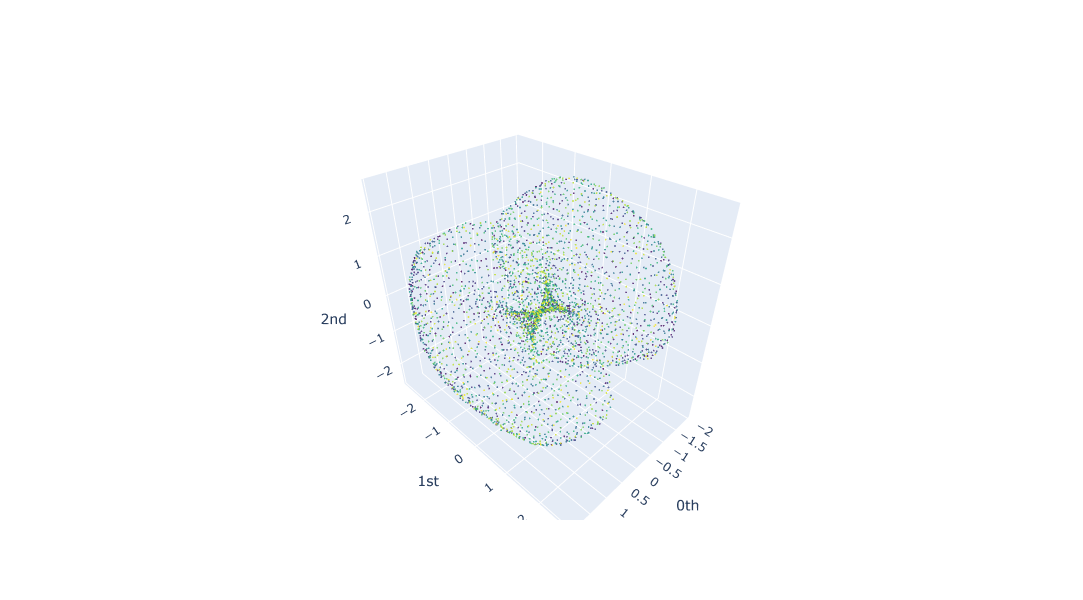

In [11]:
mask = HD.labels_ == 3
cyclo_octane_klein = cyclo_octane_nonsingular[HD.labels_ == 3]

plot_point_cloud(isomap_nonsingular[mask], plotly_params={"trace": {"marker_size": 1},
                                                          "layout": {"height": 600, "width": 600}})

# Steenrod barcode

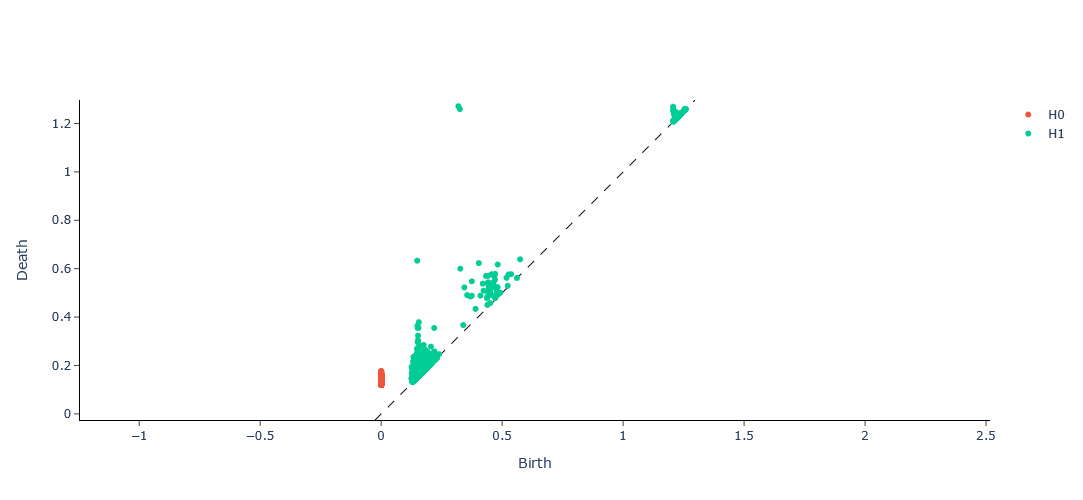

In [12]:
from gtda.homology import VietorisRipsPersistence

VietorisRipsPersistence().fit_transform_plot([cyclo_octane_klein]);

We construct a Rips filtration of the selected dataset, allegedly a Klein bottle.

In [22]:
simplex_tree = gudhi.RipsComplex(points=cyclo_octane_klein, max_edge_length=1.2).\
    create_simplex_tree(max_dimension=1)

for i, _ in enumerate(simplex_tree.get_filtration()):
        pass

len_filtration = i + 1
print(f"Filtration with {len_filtration} simplices up to dimension 1 initially")

Filtration with 412660 simplices up to dimension 1 initially


This filtration is too large to be handled by Steenroder in a reasonable amount of time when expanded all the way to dimension 3, so we apply edge collapses iteratively. *Caution: this step may take a while to run*

In [23]:
while True:
    simplex_tree.collapse_edges()

    for i, _ in enumerate(simplex_tree.get_filtration()):
        pass

    if i + 1 == len_filtration:
        break
    else:
        len_filtration = i + 1
        print(f"{len_filtration} simplices up to dimension 1")

14899 simplices up to dimension 1
14325 simplices up to dimension 1
14263 simplices up to dimension 1
14240 simplices up to dimension 1
14220 simplices up to dimension 1
14206 simplices up to dimension 1
14201 simplices up to dimension 1


We now construct the full Rips filtration up to dimension-3 simplices, and run Steenroder:

In [24]:
simplex_tree.expansion(3)  # Get the three-simplices after collapse

filtration = []
filtration_values = []
for s in simplex_tree.get_filtration():
    filtration.append(tuple(s[0]))
    filtration_values.append(s[1])

filtration_values = np.asarray(filtration_values, dtype=np.float64)

print(f"Filtration with {len(filtration)} simplices up to dimension 3")

Filtration with 21344 simplices up to dimension 3


In [25]:
k = 1

barcode, st_barcode = barcodes(
    k,
    filtration,
    homology=True,
    filtration_values=filtration_values,
    return_filtration_values=True,
    verbose=True
    )

st_barcode

Usual barcode computed, time taken: 0.11582612991333008
Steenrod matrix computed, time taken: 12.575163841247559
Steenrod barcode computed, time taken: 0.15358304977416992


[array([], dtype=float64),
 array([[0.14873308, 0.31883635]]),
 array([[0.32500443,        inf]]),
 array([], dtype=float64)]